In [1]:
%%capture
# IMPORTS
import io
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from scipy.signal import find_peaks
import scipy.io as sio
import GDI
import seaborn as sns
from IPython.utils import io as uio

In [2]:
# PARAMETERS
M           = 3
bin_width   = 30
boot_iter   = 500
time_max    = 300
num_neurons = 11

In [3]:
# LOAD DATA
SNNAP_output = []
with io.open("arb.out", mode="r", encoding="utf-8") as f:
    for line in f:
        SNNAP_output.append([float(i) for i in line.split()])
        if SNNAP_output[-1][0]>=time_max:
            break

# CONVERT TO ARRAY
SNNAP_output_array = np.asarray(SNNAP_output)

# TIME+VOLTAGES
time = SNNAP_output_array[:,0]
time_step = time[1]-time[0]
# FOR THE VOLTAGE TRACES, IGNORE FINAL TRACE (REDUNDANT)
volts = SNNAP_output_array[:,1:(num_neurons+1)]

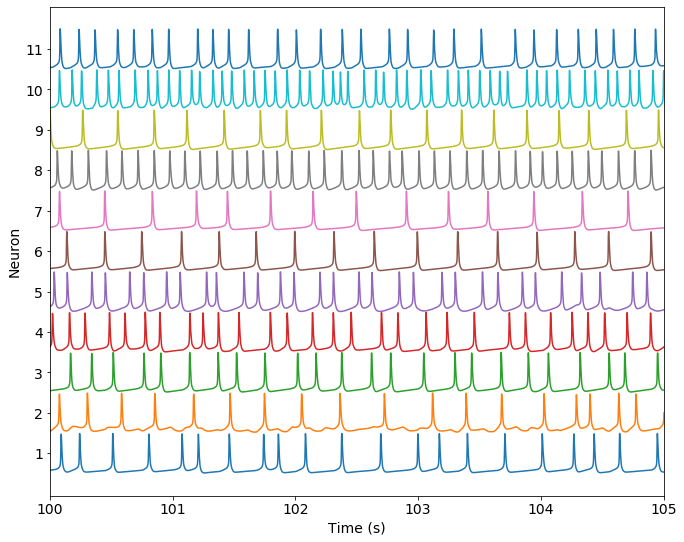

In [4]:
# PLOT 
f, ax = plt.subplots(figsize=(11, 9))
for ii in range(volts.shape[1]):
    plt.plot(time, ii+0.5+(volts[:,ii]-np.min(volts[:,ii]))/(np.max(volts[:,ii])-np.min(volts[:,ii])), 
    label='Neuron = %i'%(ii+1));

plt.xlim((100,105));
plt.xlabel('Time (s)');
plt.ylabel('Neuron');
plt.yticks(np.arange(11)+1);

In [5]:
binned_spikes = np.zeros(volts.shape)
for ii in range(volts.shape[1]):
    peaks = find_peaks(volts[:,ii], height=0)
    binned_spikes[peaks[0],ii] = 1

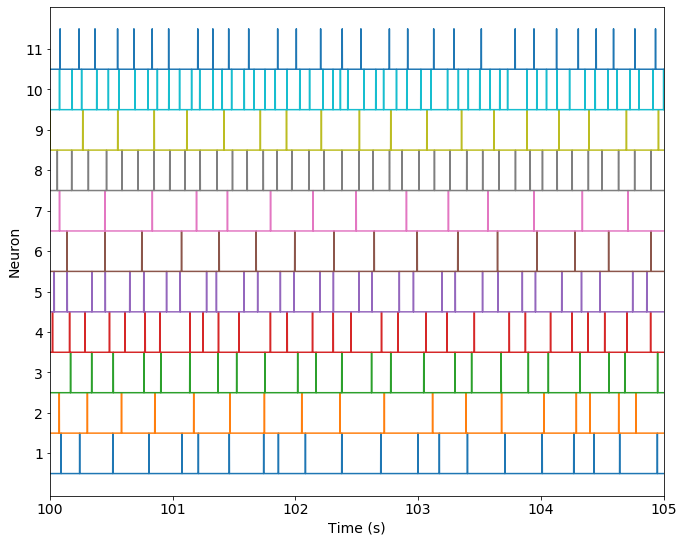

In [6]:
# PLOT binned_spikes
f, ax = plt.subplots(figsize=(11, 9))
for ii in range(binned_spikes.shape[1]):
    plt.plot(time, ii+0.5+binned_spikes[:,ii], label='Neuron = %i'%(ii+1));

plt.xlim((100,105));
plt.xlabel('Time (s)');
plt.ylabel('Neuron');
plt.yticks(np.arange(11)+1);

In [7]:
# FURTHER BIN SPIKE TIMES
num_bins = np.ceil(time_max/(bin_width*0.001))
range_max = num_bins*(bin_width*0.001)
further_binned_spikes = np.zeros((int(num_bins),volts.shape[1]))
for ii in range(volts.shape[1]):
    further_binned_spikes[:,ii], time_further_binned = np.histogram(time[binned_spikes[:,ii].astype(bool)],
                     bins=np.arange(0,range_max+((bin_width*0.001)/2),(bin_width*0.001)))

# CAP BINS TO 1 SPIKE
further_binned_spikes[further_binned_spikes>0]=1

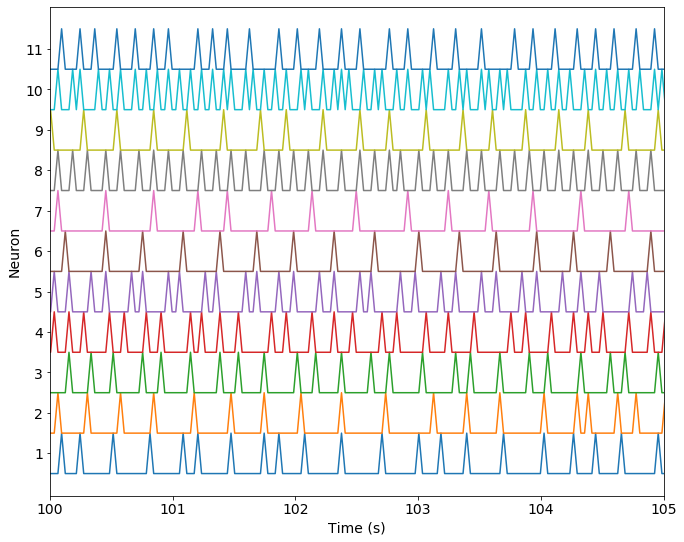

In [8]:
# PLOT further_binned_spikes
f, ax = plt.subplots(figsize=(11, 9))
for ii in range(further_binned_spikes.shape[1]):
    plt.plot(time_further_binned[:-1]+((bin_width*0.001)/2), ii+0.5+further_binned_spikes[:,ii], label='Neuron = %i'%(ii+1));

plt.xlim((100,105));
plt.xlabel('Time (s)');
plt.ylabel('Neuron');
plt.yticks(np.arange(11)+1);

In [9]:
%%capture
# LOAD NORMALIZATION
HMatrix = sio.loadmat('11neuron_normalization.mat')['HMatrix']

with uio.capture_output() as captured:
    DI_est  = GDI.DI(further_binned_spikes,M,boot_iter)
    DI_est_norm = DI_est*(1/np.log(2))/HMatrix
    DI_est_norm[DI_est_norm<0.01] = 0

    GDI_est = GDI.GDI_mask(further_binned_spikes,M,boot_iter,DI_est_norm>0)
    GDI_est_norm = GDI_est*(1/np.log(2))/HMatrix
    GDI_est_norm[GDI_est_norm<0]=0

In [10]:
GDI_sign, DI_sign = GDI.sign_inference(further_binned_spikes,M)

DI_est_norm_signed = DI_est_norm*DI_sign
GDI_est_norm_signed = GDI_est_norm*GDI_sign

# REMOVE NANs
DI_est_norm_signed[np.eye(num_neurons).astype(bool)] = 0
GDI_est_norm_signed[np.eye(num_neurons).astype(bool)] = 0

In [11]:
# Define true connectivity matrix which has +/- 1s for connection and 0s for no connection
true_conn = np.zeros((num_neurons,num_neurons))

true_conn[5,0]  = 1
true_conn[5,2]  = 1
true_conn[5,4]  = -1

true_conn[5,1]  = 1
true_conn[7,1]  = -1
true_conn[8,1]  = 1

true_conn[2,9] = 1
true_conn[4,9] = 1

true_conn[0,3]  = 1
true_conn[3,10] = 1

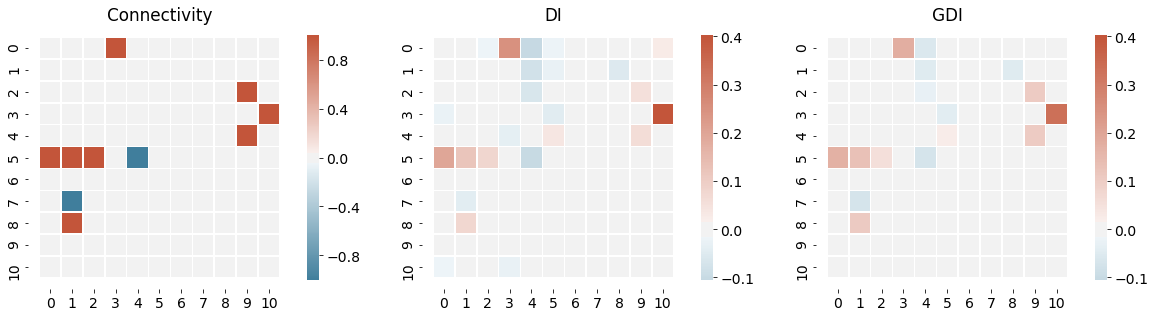

In [12]:
# Plot 
f, ax = plt.subplots(figsize=(20, 9))

# Colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# True Connectivity
plt.subplot(131)
sns.heatmap(true_conn, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.xlim((-0.5, num_neurons+0.5))
plt.ylim((num_neurons+0.5,-0.5))
plt.title('Connectivity');

# DI
plt.subplot(132)
sns.heatmap(DI_est_norm_signed, cmap=cmap, center=0,
            vmax = np.max(np.stack((DI_est_norm_signed,GDI_est_norm_signed))),
            vmin = np.min(np.stack((DI_est_norm_signed,GDI_est_norm_signed))),
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

plt.xlim((-0.5, num_neurons+0.5))
plt.ylim((num_neurons+0.5,-0.5))
plt.title('DI');

# GDI
plt.subplot(133)
sns.heatmap(GDI_est_norm_signed, cmap=cmap, center=0,
            vmax = np.max(np.stack((DI_est_norm_signed,GDI_est_norm_signed))),
            vmin = np.min(np.stack((DI_est_norm_signed,GDI_est_norm_signed))),
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

plt.xlim((-0.5, num_neurons+0.5))
plt.ylim((num_neurons+0.5,-0.5))
plt.title('GDI');

In [13]:
from scipy.io import savemat
data_to_save = {"true_conn": true_conn, "DI_est_norm_signed": DI_est_norm_signed, 
        "GDI_est_norm_signed": GDI_est_norm_signed}
savemat("data.mat", data_to_save)